In [1]:
import numpy as np
import random
import scipy
from scipy import interpolate
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init
from torch.nn.init import xavier_normal_, xavier_uniform_
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.utils as torch_utils
import torch.nn.functional as F
import numpy as np
import os
import pickle
import pandas as pd


In [199]:
path = "VAE  16 variables.pt"
device = 'cuda'
vae = VAE(16).to(device)
vae.load_state_dict(torch.load(path))
path = r'\\Latents\\'
safeheart_latents = np.load(path + 'NN_16latents.npy')

93184


In [5]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    return total_params
count_parameters(vae)

20041121

# Factor traversal

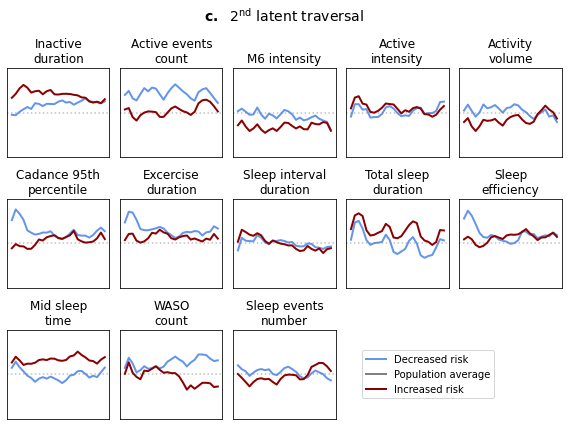

In [268]:
import scipy.ndimage
from __future__ import print_function
from collections import OrderedDict
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import os
import numpy as np 
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

from matplotlib.patches import FancyArrowPatch
seed_value = 1
torch.manual_seed(seed_value)
np.random.seed(seed_value)
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
X = safeheart_latents
X = np.mean(X, axis=0)
X = X[np.newaxis, :]

decoded_1 = []
decoded_2 = []
decoded_3 = []
decoded_4 = []
decoded_5 = []

factor_idx = 2

factor = X[:, factor_idx-1]

low_5  = (np.percentile(X, 10, axis=(0,1)))
high_5 = (np.percentile(X, 90, axis=(0,1)))

mean_value = np.mean(factor) 
traverse_range = np.array([low_5, low_3, mean_value, high_3, high_5])
for i, traverse_value in enumerate(traverse_range):
    X[:, factor_idx] = traverse_value

    encoded_traverse = torch.Tensor(X).to(device)

    with torch.no_grad():
        decoded_output = vae.decode(encoded_traverse)
    if i == 0:
        decoded_1.append(decoded_output)
    elif i == 1:
        decoded_2.append(decoded_output)
    elif i == 2:
        decoded_3.append(decoded_output)
    elif i == 3:
        decoded_4.append(decoded_output)
    elif i == 4:
        decoded_5.append(decoded_output)

sigs_ls1 = []
sigs_ls2 = []
sigs_ls3 = []
sigs_ls4 = []
sigs_ls5 = []

for i in range(13):
    sigs_1 = [decoded_1[j][0,0,i,:].cpu().detach().numpy() for j in range(X.shape[0])]
    sigs_2 = [decoded_2[j][0,0,i,:].cpu().detach().numpy() for j in range(X.shape[0])]
    sigs_3 = [decoded_3[j][0,0,i,:].cpu().detach().numpy() for j in range(X.shape[0])]
    sigs_4 = [decoded_4[j][0,0,i,:].cpu().detach().numpy() for j in range(X.shape[0])]
    sigs_5 = [decoded_5[j][0,0,i,:].cpu().detach().numpy() for j in range(X.shape[0])]

    mean_1 = np.median(sigs_1, axis=0)
    mean_2 = np.median(sigs_2, axis=0)
    mean_3 = np.median(sigs_3, axis=0)
    mean_4 = np.median(sigs_4, axis=0)
    mean_5 = np.median(sigs_5, axis=0)
    
    sigs_ls1.append(mean_1)
    sigs_ls2.append(mean_2)
    sigs_ls3.append(mean_3)
    sigs_ls4.append(mean_4)
    sigs_ls5.append(mean_5)

mean_1_ = np.stack(sigs_ls1, axis=1)
mean_2_ = np.stack(sigs_ls2, axis=1)
mean_3_ = np.stack(sigs_ls3, axis=1)
mean_4_ = np.stack(sigs_ls4, axis=1)
mean_5_ = np.stack(sigs_ls5, axis=1)

num_metrics = 13
num_rows = 3
num_cols =5

colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))

without_multicor =  ['Inactive\nduration',
 'Active events\ncount',
 'M6 intensity',
 'Active\nintensity',
 'Activity\nvolume',
 'Sleep interval\nduration',
 'Total sleep\nduration',
 'Sleep\nefficiency',
 'Mid sleep\ntime',
 'WASO\ncount',
 'Sleep events\nnumber',
 'Cadance 95th\npercentile',
 'Excercise\nduration']
from scipy.signal import savgol_filter

window_size = 25
pol = 10
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8, 6))

colors = plt.cm.RdYlGn(np.linspace(0, 1, 5))
time_points = np.arange(1, 26)

for i, metric in enumerate(without_multicor):
    new_order = [0,1,2,3,4,11,12,5, 6,7,8,9,10, 13]
    new_i = new_order[i]
    metric = without_multicor[new_i]

    row = i // num_cols
    col = i % num_cols
    ax = axs[row, col]
    
    smoothed_mean_1 = savgol_filter(mean_1_[:, i], window_size, pol)
    smoothed_mean_5 = savgol_filter(mean_5_[:, i], window_size, pol)
    smoothed_mean_3 = savgol_filter(mean_3_[:, i], window_size, pol)


    ax.plot(time_points, mean_1_[:-3, i], c='cornflowerblue',  alpha=1,linewidth=2, label='Low latent value')  # Red
    ax.axhline(y=0, color='gray', linestyle=':', alpha=0.5)  # Add horizontal line at y=0
    ax.set_ylim(-.35,.35)
    ax.plot(time_points, mean_5_[:-3, i], c='darkred', alpha=1, linewidth=2, label='High latent value')  # Green
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(metric)
 
    for ax in axs.flat[num_metrics:]:
        ax.axis('off')
        

plt.suptitle(r"$\bf{c.}$  2$^{\mathrm{nd}}$ latent traversal", fontsize=14)
plt.tight_layout()

custom_legend = [('Decreased risk', 'cornflowerblue'),('Population average', 'gray'),  ('Increased risk', 'darkred')]
handles = [plt.Line2D([0], [0], color=color, linewidth=2, linestyle='-') for label, color in custom_legend]
labels = [label for label, color in custom_legend]
plt.legend(handles, labels, loc='center left', ncol=1, bbox_to_anchor=(-1, .5))
plt.show()


# GradCAM

In [269]:
path = r'\\Latents\\'
safeheart_latents = np.load(path + 'NN_16latents.npy')
path = r'\\Clinical vector\\'
y = np.load(path + 'Endpoint vector_novelVAE.npy')
X = np.load(path + 'Wearable vector_novelVAE.npy')
X = np.transpose(X, (0,2,1))
clin = np.load(path + 'Clinical vector_novelVAE.npy')

indices_of_ones = np.where(y == 1)[0]
print("Indices where y == 1:", indices_of_ones)

titles = ['Inactive\nduration',
 'Active events\ncount',
 'M6 intensity',
 'Active\nintensity',
 'Activity\nvolume',
 'Sleep interval\nduration',
 'Total sleep\nduration',
 'Sleep\nefficiency',
 'Mid sleep\ntime',
 'WASO\ncount',
 'Sleep events\nnumber',
 'Cadance 95th\npercentile',
 'Excercise\nduration']

clinical = ['SubjectCode', 'Age', 'Sex', 'secondary_prevention_yn', 'DM', 'AF', 'HTN', 
          'HF_HFrEF', 'HFpEF', 'type_of_device_1', 'ICM', 'DCM', 'HCM', 'ACEi', 
          'ARB', 'loop_diuretics', 'betablocker', 'calcium_channel_blockers', 
          'ADD_class_II', 'AAD_class_I', 'AAS_class_III', 'nitrates', 'NOAK', 
          'ASA', 'other_anti_platelet', 'Coumarin_Warfarin', 'lipid_lowering_drugs', 
          'MI', 'BMI', 'y']
clin_y = np.hstack((clin, y))
a = pd.DataFrame(clin_y, columns=clinical)
ends = a[a['y'] == 1]
ends
a[a['SubjectCode']==  120016.0]

Indices where y == 1: [2348 2349 2350 2351 2352 2353 2354 2355 2356 2357 2358 2359 2360 2361
 2362 2363 2364 2365 2366 2367 2368 2369 2370 2371 2372 2373 2374 2375
 2376 2377 2378 2379 2380 2381 2382 2383 2384 2385 2386 2387 2388 2389
 2390 2391 2392 2393 2394 2395 2396 2397 2398 2399 2400 2401 2402 2403]
(2404, 13, 28)
(2404, 1)
(2404, 29)
[120012.0, 120016.0, 120017.0, 120019.0, 120023.0, 120024.0, 120027.0, 120030.0, 120035.0, 120037.0, 120040.0, 120052.0, 120053.0, 120054.0, 120059.0, 120066.0, 120068.0, 120077.0, 120080.0, 120091.0, 120099.0, 110005.0, 110027.0, 110027.0, 110027.0, 110033.0, 110033.0, 110033.0, 110039.0, 110039.0, 110039.0, 110039.0, 110039.0, 110043.0, 110043.0, 120117.0, 120122.0, 120127.0, 120137.0, 120138.0, 110057.0, 110057.0, 110069.0, 110069.0, 110069.0, 110069.0, 110072.0, 110077.0, 110077.0, 110083.0, 110085.0, 110118.0, 110121.0, 110123.0, 110136.0, 110140.0]


SubjectCode       Age  Sex  secondary_prevention_yn   DM   AF  HTN  \
2349     120016.0 -0.637466  1.0                      1.0  0.0  0.0  0.0   

      HF_HFrEF  HFpEF  type_of_device_1  ...  AAS_class_III  nitrates  NOAK  \
2349       1.0    0.0               1.0  ...            1.0       0.0   0.0   

      ASA  other_anti_platelet  Coumarin_Warfarin  lipid_lowering_drugs   MI  \
2349  1.0                  0.0                0.0                   1.0  0.0   

           BMI    y  
2349  0.938462  1.0  

[1 rows x 30 columns]

2373


C:\Users\mzkolk\Anaconda3\envs\cuda\Lib\site-packages\torch\nn\modules\module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
C:\Users\mzkolk\Anaconda3\envs\cuda\Lib\site-packages\torch\nn\modules\module.py:1334: UserWarning: Using a non-full backward hook when outputs are generated by different autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_output. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when outputs are generated by different autograd Nodes "


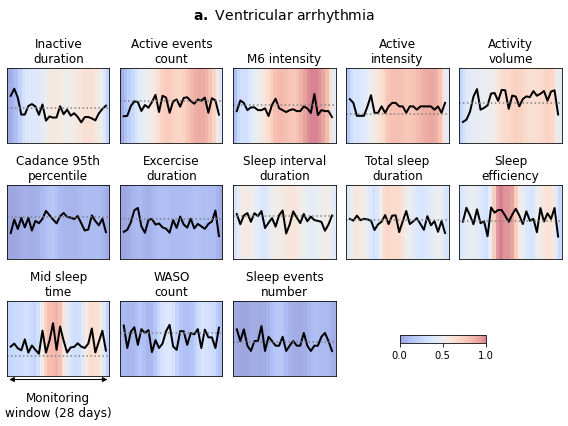

In [271]:
from __future__ import print_function
from collections import OrderedDict
import cv2
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import os
import numpy as np 
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

def default_normalizer(x) -> np.ndarray:
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    scaler = ScaleIntensity(minv=0.0, maxv=1.0)
    x = [scaler(x) for x in x]
    return np.stack(x, axis=0)

class PropBase(object):
    def __init__(self, model, target_layer, cuda=True):
        self.model = model
        self.cuda = cuda
        if self.cuda:
            self.model.cuda()
        self.model.eval()
        self.target_layer = target_layer
        self.outputs_backward = OrderedDict()
        self.outputs_forward = OrderedDict()
        self.set_hook_func()

    def set_hook_func(self):
        raise NotImplementedError

    def encode_one_hot_batch(self,z, idx):
        one_hot_batch = torch.FloatTensor(z.size()).zero_()
        one_hot_batch[0][idx] = 1.0
        return one_hot_batch

    # back prop the one_hot signal
    def backward(self, z, idx):
        self.model.zero_grad()
        self.z = z 
        one_hot = self.encode_one_hot_batch(z, idx)# this returns mu
        if self.cuda:
            one_hot = one_hot.cuda()
        flag=2
        if flag == 1:
            self.score_fc = torch.sum(F.relu(one_hot * z))
        else:
            self.score_fc = z[0,idx]
        self.score_fc.backward(retain_graph=True)
    
    def get_conv_outputs(self, outputs, target_layer): 
        for key, value in outputs.items():
            for module in self.model.named_modules():
                if id(module[1]) == key:
                    if module[0] == target_layer:                        
                        return value
        raise ValueError('invalid layer name: {}'.format(target_layer))

class attribute_wise_attn(PropBase):
    def set_hook_func(self):
        def func_b(module, grad_in, grad_out):
            self.outputs_backward[id(module)] = grad_out[0].cpu()
        def func_f(module, input, f_output):
            self.outputs_forward[id(module)] = f_output
        for module in self.model.named_modules():
            module[1].register_backward_hook(func_b)
            module[1].register_forward_hook(func_f)
            
    def normalize(self, grads):
        l2_norm = torch.sqrt(torch.mean(torch.pow(grads, 2))) + 1e-5
        return grads / l2_norm.item()

    def compute_gradient_weights(self):
        self.grads = self.normalize(self.grads)
        self.map_size = self.grads.size()[2:]
        self.weights = nn.AvgPool2d(self.map_size)(self.grads)

    def generate(self, device='cuda'):
        self.grads = self.get_conv_outputs(self.outputs_backward, self.target_layer)
        self.compute_gradient_weights()
        self.activation = self.get_conv_outputs(self.outputs_forward, self.target_layer)
        self.weights = self.weights.to(device).detach()
        
        cam = torch.zeros((self.activation.size(1), self.activation.size(2), self.activation.size(3)), dtype=torch.float32, device=device)

        for i, w in enumerate(self.weights[0]):
            cam += w * self.activation[0, i]
            
        epsilon = 1e-8
        cam = F.relu(cam)
        cam /= (torch.max(cam) + epsilon) 
        cam = cam.unsqueeze(0).unsqueeze(0)

        cam_resized = F.interpolate(cam, size=(1, 13, 28), mode='trilinear', align_corners=False)
        cam_resized = cam_resized[0, 0].cpu().detach().numpy()
        return cam_resized

def visualize_attention_ecg(vae_ecg, ecgs, patient_id, device, cmap_set='viridis', alpha_cmap=1, 
                            multiple_latents=False, list_of_latents=[]):
    attention_visualizer = attribute_wise_attn(vae_ecg, target_layer='encoder.7.conv2', cuda=True)
    input_example = torch.tensor(ecgs[patient_id:patient_id+1,:,:]).to(torch.float32).to(device)
    input_example = input_example.unsqueeze(1)
    x_recon, z_ecg, _, _ = vae_ecg(input_example)
    if multiple_latents:
        attention_maps = []
        for latent in list_of_latents:
            attention_visualizer.backward(z_ecg, latent-1)
            attention_map = attention_visualizer.generate()
            attention_map = attention_map.reshape(13, 28)
            attention_maps.append(attention_map)
            
        attention_maps = np.array(attention_maps)    
        avg_attention_map = np.mean(attention_maps, axis=0)
        x_recon = x_recon.cpu().detach().numpy()
        avg_attention_map = scipy.ndimage.gaussian_filter(avg_attention_map, sigma=1)
        attention_maps = (avg_attention_map - np.min(avg_attention_map)) / (np.max(avg_attention_map) - np.min(avg_attention_map))

        fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(8, 6))  
        plt.subplots_adjust(wspace=0.5, hspace=0.5)
        signal = input_example.cpu().detach().numpy()
        for lead_idx, ax in enumerate(axes.flat): 
            print(lead_idx)
            new_order = [0,1,2,3,4,11,12,5, 6,7,8,9,10, 13]
            if lead_idx < 13:
                lead_idx = new_order[lead_idx]

                marg = 2
                im = ax.imshow(np.expand_dims(attention_maps[lead_idx, :], axis=0), alpha=.5, 
                               cmap=cmap_set, aspect='auto', 
                               vmin=0, vmax=1, 
                                extent=[-1, signal.shape[3], np.min(signal[0, 0, lead_idx, :]-marg),
                                        np.max(signal[0, 0, lead_idx, :]+marg,0 )])
                ax.plot(signal[0, 0, lead_idx, :], color='black', alpha=1, linewidth=2)  
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlim(-1, 28)
                ax.axhline(y=0, color='gray', linestyle=':', alpha=1)  
                ax.set_xlabel('')
                ax.set_title(f'{titles[lead_idx]}', fontsize=12) 
            else:
                ax.axis('off')  
                
            if lead_idx == 8:
                ax.set_xlabel('Monitoring\nwindow (28 days)', fontsize=12, labelpad=15)  # Add x-label
                ax.annotate('', xy=(1, -0.05), xycoords='axes fraction', xytext=(0.0, -0.05), 
                            arrowprops=dict(facecolor='black',arrowstyle='<|-|>'))
        plt.suptitle(r"$\bf{a.}$ Ventricular arrhythmia", fontsize=14)
        plt.tight_layout()    
        cbar_ax = fig.add_axes([0.7, 0.2, 0.15, 0.02])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('', labelpad=10)
        plt.show()
        
visualize_attention_ecg(vae, X, patient_id=i, cmap_set='coolwarm', device='cuda', alpha_cmap=1,
                        list_of_latents=[1,2,7,8,10,11,13], multiple_latents=True)